In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from preprocessing import vocab_size
import matplotlib.pyplot as plt
from tensorflow import keras
from model_definition import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

### Import the Data

Load in different data splits from files

In [3]:
with open('./data/train_preprocessed_routes', 'rb') as f:
    X_train, y_train = pickle.load(f).values()
with open('./data/test_preprocessed_routes', 'rb') as f:
    X_test, y_test = pickle.load(f).values()
with open('./data/val_preprocessed_routes', 'rb') as f:
    X_val, y_val = pickle.load(f).values()

Mask Grade with CLS token

In [4]:
X_train[:, 0] = 3
X_test[:, 0] = 3
X_val[:, 0] = 3

In [5]:
np.shape(X_train)

(19076, 22)

In [6]:
X_train[0]

array([  3,   5,   7,  75,  74, 106, 128, 170, 183, 215,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

### Model Training

In [21]:
num_layers = 4
d_model = 96
dff = 512
num_heads = 10
dropout_rate = 0.275
epochs = 100
warmup_steps = 3000

num_classes = len(np.unique(y_train))
batch_size = 192
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train) 
class_weights=dict(zip(np.unique(y_train), class_weights))

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [23]:
def get_compiled_model():    
    learning_rate = CustomSchedule(d_model, warmup_steps=warmup_steps)
        
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.7825, beta_2=0.95, epsilon=4.59e-8)
    
    model = EncoderClassifier(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=vocab_size,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        activation='swish',
        sequential=False
    )
    
    model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=optimizer,
            metrics=['accuracy'])
    
    return model

In [25]:
import os
checkpoint_path = "model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callback = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path, 
            save_weights_only=True,
            monitor='val_accuracy',
            save_best_only=True,
            initial_value_threshold=0.49,
            verbose=1)

In [26]:
model = get_compiled_model()
history = model.fit(train_dataset, batch_size=batch_size, epochs=epochs, \
                        validation_data=val_dataset, verbose=1, callbacks = [my_callback])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 2.3569 - accuracy: 0.1697
Epoch 1: val_accuracy did not improve from 0.49000
100/100 [==============================] - 17s 75ms/step - loss: 2.3569 - accuracy: 0.1697 - val_loss: 1.8096 - val_accuracy: 0.3333
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 1.9005 - accuracy: 0.2596
Epoch 2: val_accuracy did not improve from 0.49000
100/100 [==============================] - 5s 50ms/step - loss: 1.8996 - accuracy: 0.2599 - val_loss: 1.3953 - val_accuracy: 0.4583
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 1.5509 - accuracy: 0.3517
Epoch 3: val_accuracy did not improve from 0.49000
100/100 [==============================] - 5s 51ms/step - loss: 1.5509 - accuracy: 0.3516 - val_loss: 1.3073 - val_accuracy: 0.4698
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 1.4327 - accuracy: 0.3901
Epoch 4: val_accuracy did not improve from 0.49000
100/100 [==

Epoch 30/100
 99/100 [============================>.] - ETA: 0s - loss: 1.1131 - accuracy: 0.5359
Epoch 30: val_accuracy did not improve from 0.49470
100/100 [==============================] - 5s 52ms/step - loss: 1.1128 - accuracy: 0.5359 - val_loss: 1.3742 - val_accuracy: 0.4790
Epoch 31/100
 99/100 [============================>.] - ETA: 0s - loss: 1.1093 - accuracy: 0.5400
Epoch 31: val_accuracy did not improve from 0.49470
100/100 [==============================] - 5s 52ms/step - loss: 1.1098 - accuracy: 0.5399 - val_loss: 1.3693 - val_accuracy: 0.4735
Epoch 32/100
 99/100 [============================>.] - ETA: 0s - loss: 1.1050 - accuracy: 0.5413
Epoch 32: val_accuracy did not improve from 0.49470
100/100 [==============================] - 5s 51ms/step - loss: 1.1046 - accuracy: 0.5415 - val_loss: 1.3125 - val_accuracy: 0.4804
Epoch 33/100
100/100 [==============================] - ETA: 0s - loss: 1.0894 - accuracy: 0.5491
Epoch 33: val_accuracy did not improve from 0.49470
100/

 99/100 [============================>.] - ETA: 0s - loss: 0.8713 - accuracy: 0.6511
Epoch 59: val_accuracy did not improve from 0.49470
100/100 [==============================] - 5s 52ms/step - loss: 0.8708 - accuracy: 0.6512 - val_loss: 1.4959 - val_accuracy: 0.4855
Epoch 60/100
100/100 [==============================] - ETA: 0s - loss: 0.8639 - accuracy: 0.6562
Epoch 60: val_accuracy did not improve from 0.49470
100/100 [==============================] - 5s 52ms/step - loss: 0.8639 - accuracy: 0.6562 - val_loss: 1.4861 - val_accuracy: 0.4804
Epoch 61/100
 99/100 [============================>.] - ETA: 0s - loss: 0.8437 - accuracy: 0.6657
Epoch 61: val_accuracy did not improve from 0.49470
100/100 [==============================] - 5s 52ms/step - loss: 0.8435 - accuracy: 0.6655 - val_loss: 1.4940 - val_accuracy: 0.4744
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 0.8440 - accuracy: 0.6665
Epoch 62: val_accuracy did not improve from 0.49470
100/100 [========

 99/100 [============================>.] - ETA: 0s - loss: 0.6885 - accuracy: 0.7348
Epoch 88: val_accuracy did not improve from 0.49470
100/100 [==============================] - 5s 52ms/step - loss: 0.6881 - accuracy: 0.7350 - val_loss: 1.6343 - val_accuracy: 0.4767
Epoch 89/100
100/100 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.7411
Epoch 89: val_accuracy did not improve from 0.49470
100/100 [==============================] - 5s 52ms/step - loss: 0.6736 - accuracy: 0.7411 - val_loss: 1.6682 - val_accuracy: 0.4730
Epoch 90/100
100/100 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.7459
Epoch 90: val_accuracy did not improve from 0.49470
100/100 [==============================] - 5s 52ms/step - loss: 0.6730 - accuracy: 0.7459 - val_loss: 1.6596 - val_accuracy: 0.4712
Epoch 91/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6696 - accuracy: 0.7461
Epoch 91: val_accuracy did not improve from 0.49470
100/100 [========

In [27]:
# Creates the base model 
new_model = get_compiled_model()

In [28]:
# The base model only gets about ~20% accuracy as it is not trained at all 
# This is to show that the base model before loading the weights is not trained
# and its accuracy is not good.
new_model.evaluate(X_test, y_test, batch_size=batch_size)

12/12 [==============================] - 2s 29ms/step - loss: 4.1626 - accuracy: 0.0350


[4.162576675415039, 0.0350230410695076]

In [29]:
# This loads the weights of the model that was saved at a certain epoch and val_accuracy
epoch = np.argmax(history.history['val_accuracy'])
val_accuracy = history.history['val_accuracy'][epoch]
epoch = epoch+1

path = f"model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
print(path)
new_model.load_weights(path)

model_weights/weights.epoch:[21]-val_acc:[0.49].hdf5


In [30]:
# After loading the weights of a previously trained model, the accuracy matches the
# best version of the model that the checkpoints were saved from
loss, acc = new_model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'loss: {loss:.4f}, accuracy: {acc:.4f}')

12/12 [==============================] - 0s 30ms/step - loss: 1.3568 - accuracy: 0.4719
loss: 1.3568, accuracy: 0.4719


In [31]:
# This is to show that the accuracy is higher than the the last epoch of the model with loaded weights.
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'loss: {loss:.4f}, accuracy: {acc:.4f}')

12/12 [==============================] - 0s 31ms/step - loss: 1.7385 - accuracy: 0.4631
loss: 1.7385, accuracy: 0.4631


### Training Plots

0.7632627487182617

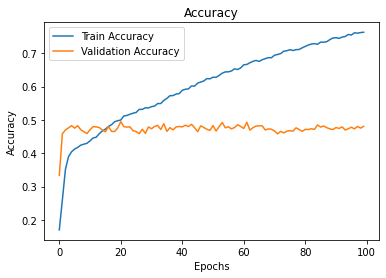

In [32]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

history.history['accuracy'][np.argmax(history.history['accuracy'])]

2.3569395542144775

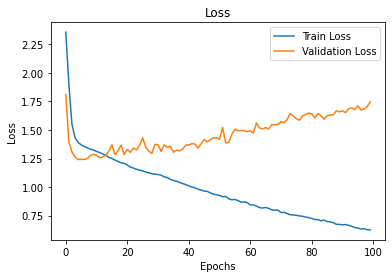

In [33]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

history.history['loss'][np.argmax(history.history['loss'])]

100.0


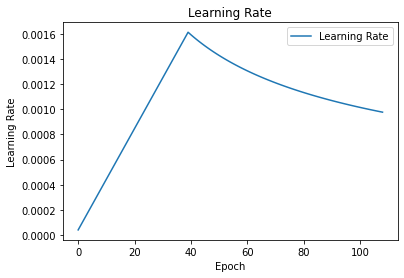

In [34]:
learning_rate = CustomSchedule(d_model)
steps_per_epoch = np.ceil((np.shape(X_train)[0]/batch_size))
print(steps_per_epoch)
lr = np.array([])
for i in range(1, np.maximum(epochs+10, 30)):
    lr = np.append(lr, learning_rate.__call__(i*steps_per_epoch))
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.plot(lr, label='Learning Rate')
plt.legend()


### Model Evaluation

In [35]:
epoch = np.argmax(history.history['val_accuracy'])
loss = history.history['loss'][epoch]
accuracy = history.history['accuracy'][epoch]
val_loss = history.history['val_loss'][epoch]
val_accuracy = history.history['val_accuracy'][epoch]
epoch += 1

print(f'best epoch: {epoch}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')

best epoch: 21, loss: 1.1932, accuracy: 0.4998, val_loss: 1.3302, val_accuracy: 0.4947


In [36]:
path = f"model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
print(path)
test_model = get_compiled_model()
test_model.build((19072,22))
test_model.load_weights(path)

model_weights/weights.epoch:[21]-val_acc:[0.49].hdf5


In [37]:
pred = test_model.predict(X_test)

68/68 [==============================] - 1s 11ms/step


In [38]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
def un_norm_cm(norm_cm):
    np.array([
        cm[i] / np.sum(cm[i]) for i in range(len(cm))
    ])
    
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()
def top_1_accuracy(cm):
    return (cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum()) / cm.sum()
def top_2_accuracy(cm):
    return (cm.diagonal(-2).sum() + cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum() +
                 cm.diagonal(2).sum()) / cm.sum()

In [39]:
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))
print('+-1 accuracy', top_1_accuracy(cm))
print('+-2 accuracy', top_2_accuracy(cm))

accuracy 0.471889400921659
+-1 accuracy 0.8073732718894009
+-2 accuracy 0.9447004608294931


Heatmap

<AxesSubplot:>

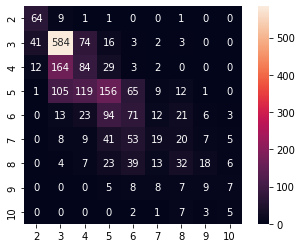

In [40]:
sns.heatmap(cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='g', square=True)

Normalized Heatmap

<AxesSubplot:>

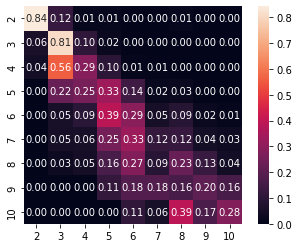

In [41]:
sns.heatmap(normalized_cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='.2f', square=True)